# Oldies but Goldies Project: Decision Trees and Neural Networks

<p style="text-align: center;">Leander Girrbach <br> <a href="mailto:girrbach@cl.uni-heidelberg.de">girrbach@cl.uni-heidelberg.de</a></p>


**Important note**: This project consists of 2 parts:
 1. Differentiable decision trees
 2. Distilling neural networks into (conventional) decision trees

Both parts explore different ideas for combining neural networks (mostly MLPs) and decision trees (or random forests).

## Part 1: Differentiable Decision Trees
### Introduction & Motivation

The aim of of this first part of the project is to implement differentiable decision trees that can be trained by backpropagation. Of course, we want to compare differentiable decision trees both to standard decision trees and to regular neural networks (MLPs in this case). The reference paper which I reimplement is [1]. 

Before we start with the implementation, we have to answer the question why we want to do that. Neural networks show good performance, for example in learning to solve classification tasks. However, neural networks are not interpretable by humans. It would be extremely hard or impossible to figure out what the learned transformations mean in comprehensible terms. Decision Trees also show good performance, but more importantly, their classification is easy to understand by humans. Therefore, this project aims at combining techniques from deep learning (neural networks) and the interpretability of decision trees.

This part of the project consists of 2 parts:

 1. First, I will develop the implementation of differentiable decision trees
 2. I will evaluate the implementation on text classification tasks and compare the performance to the performance of other models

[1] Frosst, Nicholas, and Geoffrey Hinton. "Distilling a neural network into a soft decision tree." arXiv preprint arXiv:1711.09784 (2017)

---

Let's first import some important packages.

In [1]:
# PyTorch functionality
import torch
import torch.nn as nn
from torch.optim import AdamW
from torch.nn.utils import clip_grad_norm_

# Other misc packages
import spacy
import warnings
import numpy as np
import matplotlib.pyplot as plt

from tqdm.notebook import tqdm
from tqdm.notebook import trange

# Data
from torch.utils.data import DataLoader
from torch.utils.data import TensorDataset
from sklearn.datasets import fetch_20newsgroups

# Sklearn stuff
from sklearn.metrics import accuracy_score
from sklearn.decomposition import TruncatedSVD
from sklearn.preprocessing import LabelEncoder
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction.text import TfidfVectorizer

In [2]:
# Seeds for determinism
torch.manual_seed(123)
np.random.seed(123)

# Who cares for warnings?
warnings.filterwarnings('ignore')

---

### Methods

#### Summary of Frosst and Hinton (2017)
##### Model architecture
Frosst and Hinton propose the following approach: They represent the the differentiable decision tree as a binary tree. Each inner node computes the probability of descending to the right or left child node. The probability of descending to the right child node is given as
$$
p_i(x) = \sigma(\beta\cdot(w\cdot x + b))
$$
where $\sigma: \mathbb{R} \rightarrow (0, 1), x\mapsto \frac{1}{1+\exp(-x)}$ is the sigmoid function, $w$ is a learned weigth vector, $b$ is a learned bias, $\beta$ is a temperature hyperparameter, and $x$ is the feature vector of the input data.

Accordingly, the probability of descending to the left child node is given as $1- \sigma(\beta\cdot(w\cdot x + b))$.

Each leaf node stores a learned, constant distribution over the possible classes (called "bigot" in the paper). This means that while the distribution is learned by backpropagation, it is independent of the input.

Classification works as follows: The probabilities calculated for each node induce a probability for each leaf node. This probability is the path probability from the root to the respective leaf node. Frosst and Hinton propose two possibilities of calculating the final prediction:

 1. Calculate a weighted linear combination of the constant leaf node distributions (weighted by the path probabilities)
 2. Return the distribution with the highest probability (leaf node with highest path probability)

Only the first option allows straightforward end-to-end optimisation. Therefore, I use this option for training. While the first option more closely resembles random forests, the second option resembles (single) decision trees more closely. Therefore, I expect the first option to yield better performance.

##### Regularisation
Frosst and Hinton propose the following regularisation: For each node, they calculate $\alpha_i = \frac{\sum_x P^i(x)\cdot p_i(x)}{\sum_x P^i(x)}$ where $p_i(x)$ is the activation of node $i$ and $P^i$ is the path probability from the root node to node $i$. The sum is over all datapoints in a batch. Then, they propose to minimize the regularisation term:
$$
C = -\lambda \cdot \sum_{i} \frac{1}{2}\log\alpha_i + \frac{1}{2}\log(1-\alpha_i)
$$
This is the negative cross-entropy between the (average) probabilities of descending to the two child nodes and the uniform distribution (equal probability of descending to any child node).

#### Extension and Generalistation

The method proposed by Frosst and Hinton can be easily extended to higher node-degrees than $2$, that is, one node can have multiple children. In this case, the sigmoid activation is replaced by a softmax activation which gives the probabilities of descending to the respective child node. Furthermore, the regularisation can be replaced by a simple entropy regularisation. In order to avoid degenerate solutions, models with higher-entropy node distributions are preferred.

In [3]:
class BinarySoftDecisionTreeClassifier(nn.Module):
    def __init__(self, num_layers, num_classes, num_features, beta=1.0, gamma=0.01):
        super().__init__()
        self.inner_layers = nn.ModuleList([nn.Linear(num_features, 2**i) for i in range(num_layers)])
        self.distributions = nn.Parameter(torch.randn(2**num_layers, num_classes))
        self.sigmoid = nn.Sigmoid()
        self.softmax = nn.Softmax(dim=1)
        
        self.beta = beta
        self.gamma = gamma
        
    def forward(self, x, only_best_path=False):
        path_probs = x.new_ones(x.shape[0], 1)
        regulariser = 0.0
        for depth, layer in enumerate(self.inner_layers):
            probs = self.sigmoid(self.beta * layer(x))
            
            alpha = torch.sum(probs * path_probs, dim=0) / (torch.sum(path_probs, dim=0) + 1e-8)
            alpha = torch.clamp(alpha, 1e-6, 1-1e-6)
            layer_regulariser = 0.5 * torch.log(alpha) + 0.5 * torch.log(1-alpha)
            regulariser -= 2**(-depth) * self.gamma * torch.sum(layer_regulariser)
            
            probs = probs.unsqueeze(2)
            probs = torch.cat([probs, 1-probs], dim=2)
            probs = probs.reshape(probs.shape[0], -1).contiguous()
            
            path_probs = probs * path_probs.repeat_interleave(2, dim=1)
        
        distributions = self.softmax(self.distributions)

        if only_best_path:
            best_path = path_probs.argmax(dim=1).long()
            predictions = distributions[best_path]
        else:
            predictions = torch.log(torch.mm(path_probs, distributions))

        max_path_probability = torch.mean(torch.max(path_probs, dim=1)[0])
        return predictions, regulariser, max_path_probability

    
class SoftDecisionTreeClassifier(nn.Module):
    def __init__(self, num_layers, num_classes, num_features, out_degree=3, beta=1.0, gamma=0.01):
        super().__init__()
        self.inner_layers = nn.ModuleList(
            [nn.Linear(num_features, out_degree**(i+1)) for i in range(num_layers)]
        )
        self.distributions = nn.Parameter(torch.randn(out_degree**num_layers, num_classes))
        self.softmax = nn.Softmax(dim=-1)
        
        self.beta = beta
        self.gamma = gamma
        self.out_degree = out_degree
    
    def forward(self, x, only_best_path=False):
        path_probs = x.new_ones(x.shape[0], 1)
        regulariser = 0.0
        batch, features = x.shape
        
        for depth, layer in enumerate(self.inner_layers):
            scores = layer(x)
            scores = scores.reshape(batch, -1, self.out_degree).contiguous()
            probs = self.softmax(torch.div(scores, self.beta))
            probs = probs.reshape(batch, -1).contiguous()
            path_probs = probs * path_probs.repeat_interleave(self.out_degree, dim=1)
            
            # Add entropy regularisation
            entropy = -torch.sum(probs * torch.log(torch.clamp(probs, 1e-6, 1-1e-6)))
            entropy = torch.div(entropy, probs.shape[1])  # Normalise entropy
            regulariser += entropy * self.gamma * 2**(-depth)
        
        distributions = self.softmax(self.distributions)
        
        if only_best_path:
            best_path = path_probs.argmax(dim=1).long()
            predictions = distributions[best_path]
        else:
            predictions = torch.log(torch.mm(path_probs, distributions))

        max_path_probability = torch.mean(torch.max(path_probs, dim=1)[0])
        return predictions, regulariser, max_path_probability    

---

### Experiments

In order to evaluate the differentiable decision tree implementations, I conduct the following experiments:

 1. Hyperparameter study for depth, $\beta$, and regularisation. Here, I want to examine the effects of different value for $\beta$ and $\gamma$. Also, I want to evaluate the relation between depth and number of training epochs, that is how fast training is in relation to the tree depth.
 2. Comparison of performance of a text classification task between differentiable decision trees, decision tree classifiers, random forest classifiers, and MLPs.
 
All experiments are carried out using a binary differentiable decision tree and a ternary differentiable decision tree.

The goal of this project is not to optimise the performance of any model but rather to investigate the performance of differentiable decision trees. Therefore, it is methodologically unproblematic to report any evaluation scores on the test set and not use any validation set.

---
 
#### Data
For conducting experiments, I use the 20 newsgroups dataset as provided by `sklearn`. There are multiple reasons for using this particular dataset:
  
  * It as an easily available NLP (text classification) dataset
  * It is multiclass classification
  * It is reasonably small so that we don't need too much compute to conduct experiments

For preprocessing, I lowercase all documents. Then, I use `spacy` to tokenize and lemmatize all documents. Finally, I remove stopwords.

In order to extract feature vectors, I construct the tf-idf document-term matrix. Tokens occuring in less than $10$ documents are discarded. Furthermore, because high-dimensional data is unpractical with neural networks, I factorise the document-term matrix using SVD. Eventually, each document is represented as a $512$-dimensional feature vector.

In [4]:
train_data = fetch_20newsgroups(subset='train')
test_data = fetch_20newsgroups(subset='test')
X_train_raw, y_train = train_data.data, train_data.target
X_test_raw, y_test = test_data.data, test_data.target

spacy_preprocessor = spacy.load("en_core_web_sm", disable=["parser", "ner"])

def preprocess(documents):
    processed_documents = []
    documents = tqdm(documents)
    documents.set_description("Processing documents")
    for document in documents:
        document = document.lower()
        document = spacy_preprocessor(document)
        document = [token.lemma_ for token in document if not token.is_stop]
        processed_documents.append(" ".join(document))
    return processed_documents

X_train = preprocess(X_train_raw)
X_test = preprocess(X_test_raw)

  0%|          | 0/11314 [00:00<?, ?it/s]

  0%|          | 0/7532 [00:00<?, ?it/s]

In [5]:
print("Encoding labels by integers")
label_encoder = LabelEncoder()
label_encoder.fit(y_train)
y_train = label_encoder.transform(y_train)
y_test = label_encoder.transform(y_test)
    
print("Constructing tf-idf weighted document-term matrix")
vectoriser = TfidfVectorizer(tokenizer=str.split, min_df=10)
vectoriser.fit(X_train)
X_train = vectoriser.transform(X_train)
X_test = vectoriser.transform(X_test)

print("Performing Matrix factorisation using SVD")
svd = TruncatedSVD(n_components=512)
svd.fit(X_train)
X_train = svd.transform(X_train)
X_test = svd.transform(X_test)

print("Converting data to PyTorch Tensors & Make training dataset")
X_train_tensor = torch.from_numpy(X_train).float()
y_train_tensor = torch.from_numpy(y_train).long()
train_dataset = DataLoader(TensorDataset(X_train_tensor, y_train_tensor), batch_size=32)

X_test_tensor = torch.from_numpy(X_test).float()
y_test_tensor = torch.from_numpy(y_test).long()

pytorch_data = train_dataset, X_test_tensor, y_test_tensor

Encoding labels by integers
Constructing tf-idf weighted document-term matrix
Performing Matrix factorisation using SVD
Converting data to PyTorch Tensors & Make training dataset


#### Training of Differentiable Decision Trees

We train the models by maximising the negative log-likelihood of predicting the correct class. As optimiser I choose `AdamW` (default parameters), as `AdamW` shows much faster convergence and better results than SGD in this case. Batch size is `32` for all models. Also, I clip gradients with norm $\geq 1.0$.

Test set accuracy is evaluated and saved after every epoch.

In [6]:
def train_pytorch_classifier(classifier, data, epochs=12):
    criterion = nn.NLLLoss()
    optimiser = AdamW(classifier.parameters())
    dataset, X_test, y_test = data
    
    epoch_iter = trange(epochs, postfix={'Accuracy': 0.0, 'Loss': 0.0, 'Max. Path Prob.': 0.0}, leave=False)
    epoch_iter.set_description("Module Training Progress (Epochs)")
    running_loss = 0.0
    running_accuracy = 0.0
    running_max_path_probability = 0.0
    
    test_accuracies_comb = []
    test_accuracies_path = []

    for epoch in epoch_iter:
        for batch_idx, batch in enumerate(dataset):
            x, y = batch
            predictions, regulariser, max_path_probability = classifier(x)
            loss = criterion(predictions, y)
            accuracy = (predictions.argmax(1) == y).sum().item() / len(y) 
            
            loss += regulariser
            loss.backward()
        
            clip_grad_norm_(classifier.parameters(), 1.0)
            optimiser.step()
            optimiser.zero_grad()
            
            loss_value = loss.detach().item()
            max_path_probability = max_path_probability.detach().item()
            running_loss = (0.95 * running_loss) + (0.05 * loss_value)
            running_accuracy = (0.95 * running_accuracy) + (0.05 * accuracy)
            running_max_path_probability = (0.95 * running_max_path_probability) + (0.05 * max_path_probability)
            
            if (batch_idx + 1) % 100 == 0:
                epoch_iter.set_postfix({'Accuracy': running_accuracy,
                                        'Loss': running_loss,
                                        'Max. Path Prob.': running_max_path_probability
                                       })

        # Evaluate on test set after each epoch
        with torch.no_grad():
            test_predictions_comb, _, _ = classifier(X_test, only_best_path=False)
            test_predictions_path, _, _ = classifier(X_test, only_best_path=True)
            test_predictions_comb = torch.argmax(test_predictions_comb, dim=1)
            test_predictions_path = torch.argmax(test_predictions_path, dim=1)
            accuracy_comb = torch.sum(test_predictions_comb == y_test).item() / len(y_test)
            accuracy_path = torch.sum(test_predictions_path == y_test).item() / len(y_test)
            test_accuracies_comb.append(accuracy_comb)
            test_accuracies_path.append(accuracy_path)

    epoch_iter.close()
    return test_accuracies_comb, test_accuracies_path

---
#### Hyperparameter Evaluation
In this experiment, I want to study the effect of the $\beta$ and $\gamma$ parameters. Remember, $\beta$ as a temperature parameter influences how skewed node distributions are. Higher values of $\beta$ lead to more skewed distributions, while lower values increase entropy. $\gamma$ is the weighting of the regulariser.

The standard values are $\beta=1$ and $\gamma=0.01$. I am particularly interested in their effect on trees of varying depth. Therefore, I evaluate the following hyperparameter settings: depth = $\{2, 4, 6, 8, 10\}$, $\beta = \{0.1, 0.5, 1, 2, 10\}$ and $\gamma = \{0.001, 0.01, 0.1, 1\}$. For evaluating $\beta$, I vary the depth and $\beta$ while keeping $\gamma=0.01$. For evaluating $\gamma$, I vary the depth and $\gamma$ while keeping $\beta=1$.

All models are trained for $15$ epochs with a minibatch size of $32$.

In [7]:
binary_depth_vals = [2, 4, 6, 8, 10]
ternary_depth_vals = [2, 4, 6]
beta_vals = [0.1, 0.5, 1, 2, 10]
gamma_vals = [0.001, 0.01, 0.1, 1]

In [8]:
beta_results_binary_comb = []
beta_results_binary_path = []

for beta in beta_vals:
    current_beta_results_comb = []
    current_beta_results_path = []
    
    for depth in binary_depth_vals:
        classifier = BinarySoftDecisionTreeClassifier(depth, 20, 512, beta=beta)
        accuracies_comb, accuracies_path = train_pytorch_classifier(classifier, pytorch_data)
        current_beta_results_comb.append(accuracies_comb[-1])
        current_beta_results_path.append(accuracies_path[-1])

    beta_results_binary_comb.append(current_beta_results_comb)
    beta_results_binary_path.append(current_beta_results_path)


gamma_results_binary_comb = []
gamma_results_binary_path = []

for gamma in gamma_vals:
    current_gamma_results_comb = []
    current_gamma_results_path = []
    
    for depth in binary_depth_vals:
        classifier = BinarySoftDecisionTreeClassifier(depth, 20, 512, gamma=gamma)
        accuracies_comb, accuracies_path = train_pytorch_classifier(classifier, pytorch_data)
        current_gamma_results_comb.append(accuracies_comb[-1])
        current_gamma_results_path.append(accuracies_path[-1])
        
    gamma_results_binary_comb.append(current_gamma_results_comb)
    gamma_results_binary_path.append(current_gamma_results_path)

beta_results_ternary_comb = []
beta_results_ternary_path = []

for beta in beta_vals:
    current_beta_results_comb = []
    current_beta_results_path = []
    
    for depth in ternary_depth_vals:
        classifier = SoftDecisionTreeClassifier(depth, 20, 512, beta=beta)
        accuracies_comb, accuracies_path  = train_pytorch_classifier(classifier, pytorch_data)
        current_beta_results_comb.append(accuracies_comb[-1])
        current_beta_results_path.append(accuracies_path[-1])

    beta_results_ternary_comb.append(current_beta_results_comb)
    beta_results_ternary_path.append(current_beta_results_path)

gamma_results_ternary_comb = []
gamma_results_ternary_path = []

for gamma in gamma_vals:
    current_gamma_results_comb = []
    current_gamma_results_path = []

    for depth in ternary_depth_vals:
        classifier = SoftDecisionTreeClassifier(depth, 20, 512, gamma=gamma)
        accuracies_comb, accuracies_path = train_pytorch_classifier(classifier, pytorch_data)
        current_gamma_results_comb.append(accuracies_comb[-1])
        current_gamma_results_path.append(accuracies_path[-1])
    
    gamma_results_ternary_comb.append(current_gamma_results_comb)
    gamma_results_ternary_path.append(current_gamma_results_path)

  0%|          | 0/12 [00:00<?, ?it/s, Accuracy=0, Loss=0, Max. Path Prob.=0]

  0%|          | 0/12 [00:00<?, ?it/s, Accuracy=0, Loss=0, Max. Path Prob.=0]

  0%|          | 0/12 [00:00<?, ?it/s, Accuracy=0, Loss=0, Max. Path Prob.=0]

  0%|          | 0/12 [00:00<?, ?it/s, Accuracy=0, Loss=0, Max. Path Prob.=0]

  0%|          | 0/12 [00:00<?, ?it/s, Accuracy=0, Loss=0, Max. Path Prob.=0]

  0%|          | 0/12 [00:00<?, ?it/s, Accuracy=0, Loss=0, Max. Path Prob.=0]

  0%|          | 0/12 [00:00<?, ?it/s, Accuracy=0, Loss=0, Max. Path Prob.=0]

  0%|          | 0/12 [00:00<?, ?it/s, Accuracy=0, Loss=0, Max. Path Prob.=0]

  0%|          | 0/12 [00:00<?, ?it/s, Accuracy=0, Loss=0, Max. Path Prob.=0]

  0%|          | 0/12 [00:00<?, ?it/s, Accuracy=0, Loss=0, Max. Path Prob.=0]

  0%|          | 0/12 [00:00<?, ?it/s, Accuracy=0, Loss=0, Max. Path Prob.=0]

  0%|          | 0/12 [00:00<?, ?it/s, Accuracy=0, Loss=0, Max. Path Prob.=0]

  0%|          | 0/12 [00:00<?, ?it/s, Accuracy=0, Loss=0, Max. Path Prob.=0]

  0%|          | 0/12 [00:00<?, ?it/s, Accuracy=0, Loss=0, Max. Path Prob.=0]

  0%|          | 0/12 [00:00<?, ?it/s, Accuracy=0, Loss=0, Max. Path Prob.=0]

  0%|          | 0/12 [00:00<?, ?it/s, Accuracy=0, Loss=0, Max. Path Prob.=0]

  0%|          | 0/12 [00:00<?, ?it/s, Accuracy=0, Loss=0, Max. Path Prob.=0]

  0%|          | 0/12 [00:00<?, ?it/s, Accuracy=0, Loss=0, Max. Path Prob.=0]

  0%|          | 0/12 [00:00<?, ?it/s, Accuracy=0, Loss=0, Max. Path Prob.=0]

  0%|          | 0/12 [00:00<?, ?it/s, Accuracy=0, Loss=0, Max. Path Prob.=0]

  0%|          | 0/12 [00:00<?, ?it/s, Accuracy=0, Loss=0, Max. Path Prob.=0]

  0%|          | 0/12 [00:00<?, ?it/s, Accuracy=0, Loss=0, Max. Path Prob.=0]

  0%|          | 0/12 [00:00<?, ?it/s, Accuracy=0, Loss=0, Max. Path Prob.=0]

  0%|          | 0/12 [00:00<?, ?it/s, Accuracy=0, Loss=0, Max. Path Prob.=0]

  0%|          | 0/12 [00:00<?, ?it/s, Accuracy=0, Loss=0, Max. Path Prob.=0]

  0%|          | 0/12 [00:00<?, ?it/s, Accuracy=0, Loss=0, Max. Path Prob.=0]

  0%|          | 0/12 [00:00<?, ?it/s, Accuracy=0, Loss=0, Max. Path Prob.=0]

  0%|          | 0/12 [00:00<?, ?it/s, Accuracy=0, Loss=0, Max. Path Prob.=0]

  0%|          | 0/12 [00:00<?, ?it/s, Accuracy=0, Loss=0, Max. Path Prob.=0]

  0%|          | 0/12 [00:00<?, ?it/s, Accuracy=0, Loss=0, Max. Path Prob.=0]

  0%|          | 0/12 [00:00<?, ?it/s, Accuracy=0, Loss=0, Max. Path Prob.=0]

  0%|          | 0/12 [00:00<?, ?it/s, Accuracy=0, Loss=0, Max. Path Prob.=0]

  0%|          | 0/12 [00:00<?, ?it/s, Accuracy=0, Loss=0, Max. Path Prob.=0]

  0%|          | 0/12 [00:00<?, ?it/s, Accuracy=0, Loss=0, Max. Path Prob.=0]

  0%|          | 0/12 [00:00<?, ?it/s, Accuracy=0, Loss=0, Max. Path Prob.=0]

  0%|          | 0/12 [00:00<?, ?it/s, Accuracy=0, Loss=0, Max. Path Prob.=0]

  0%|          | 0/12 [00:00<?, ?it/s, Accuracy=0, Loss=0, Max. Path Prob.=0]

  0%|          | 0/12 [00:00<?, ?it/s, Accuracy=0, Loss=0, Max. Path Prob.=0]

  0%|          | 0/12 [00:00<?, ?it/s, Accuracy=0, Loss=0, Max. Path Prob.=0]

  0%|          | 0/12 [00:00<?, ?it/s, Accuracy=0, Loss=0, Max. Path Prob.=0]

  0%|          | 0/12 [00:00<?, ?it/s, Accuracy=0, Loss=0, Max. Path Prob.=0]

  0%|          | 0/12 [00:00<?, ?it/s, Accuracy=0, Loss=0, Max. Path Prob.=0]

  0%|          | 0/12 [00:00<?, ?it/s, Accuracy=0, Loss=0, Max. Path Prob.=0]

  0%|          | 0/12 [00:00<?, ?it/s, Accuracy=0, Loss=0, Max. Path Prob.=0]

  0%|          | 0/12 [00:00<?, ?it/s, Accuracy=0, Loss=0, Max. Path Prob.=0]

  0%|          | 0/12 [00:00<?, ?it/s, Accuracy=0, Loss=0, Max. Path Prob.=0]

  0%|          | 0/12 [00:00<?, ?it/s, Accuracy=0, Loss=0, Max. Path Prob.=0]

  0%|          | 0/12 [00:00<?, ?it/s, Accuracy=0, Loss=0, Max. Path Prob.=0]

  0%|          | 0/12 [00:00<?, ?it/s, Accuracy=0, Loss=0, Max. Path Prob.=0]

  0%|          | 0/12 [00:00<?, ?it/s, Accuracy=0, Loss=0, Max. Path Prob.=0]

  0%|          | 0/12 [00:00<?, ?it/s, Accuracy=0, Loss=0, Max. Path Prob.=0]

  0%|          | 0/12 [00:00<?, ?it/s, Accuracy=0, Loss=0, Max. Path Prob.=0]

  0%|          | 0/12 [00:00<?, ?it/s, Accuracy=0, Loss=0, Max. Path Prob.=0]

  0%|          | 0/12 [00:00<?, ?it/s, Accuracy=0, Loss=0, Max. Path Prob.=0]

  0%|          | 0/12 [00:00<?, ?it/s, Accuracy=0, Loss=0, Max. Path Prob.=0]

  0%|          | 0/12 [00:00<?, ?it/s, Accuracy=0, Loss=0, Max. Path Prob.=0]

  0%|          | 0/12 [00:00<?, ?it/s, Accuracy=0, Loss=0, Max. Path Prob.=0]

  0%|          | 0/12 [00:00<?, ?it/s, Accuracy=0, Loss=0, Max. Path Prob.=0]

  0%|          | 0/12 [00:00<?, ?it/s, Accuracy=0, Loss=0, Max. Path Prob.=0]

  0%|          | 0/12 [00:00<?, ?it/s, Accuracy=0, Loss=0, Max. Path Prob.=0]

  0%|          | 0/12 [00:00<?, ?it/s, Accuracy=0, Loss=0, Max. Path Prob.=0]

  0%|          | 0/12 [00:00<?, ?it/s, Accuracy=0, Loss=0, Max. Path Prob.=0]

  0%|          | 0/12 [00:00<?, ?it/s, Accuracy=0, Loss=0, Max. Path Prob.=0]

  0%|          | 0/12 [00:00<?, ?it/s, Accuracy=0, Loss=0, Max. Path Prob.=0]

  0%|          | 0/12 [00:00<?, ?it/s, Accuracy=0, Loss=0, Max. Path Prob.=0]

  0%|          | 0/12 [00:00<?, ?it/s, Accuracy=0, Loss=0, Max. Path Prob.=0]

  0%|          | 0/12 [00:00<?, ?it/s, Accuracy=0, Loss=0, Max. Path Prob.=0]

  0%|          | 0/12 [00:00<?, ?it/s, Accuracy=0, Loss=0, Max. Path Prob.=0]

  0%|          | 0/12 [00:00<?, ?it/s, Accuracy=0, Loss=0, Max. Path Prob.=0]

  0%|          | 0/12 [00:00<?, ?it/s, Accuracy=0, Loss=0, Max. Path Prob.=0]

  0%|          | 0/12 [00:00<?, ?it/s, Accuracy=0, Loss=0, Max. Path Prob.=0]

  0%|          | 0/12 [00:00<?, ?it/s, Accuracy=0, Loss=0, Max. Path Prob.=0]

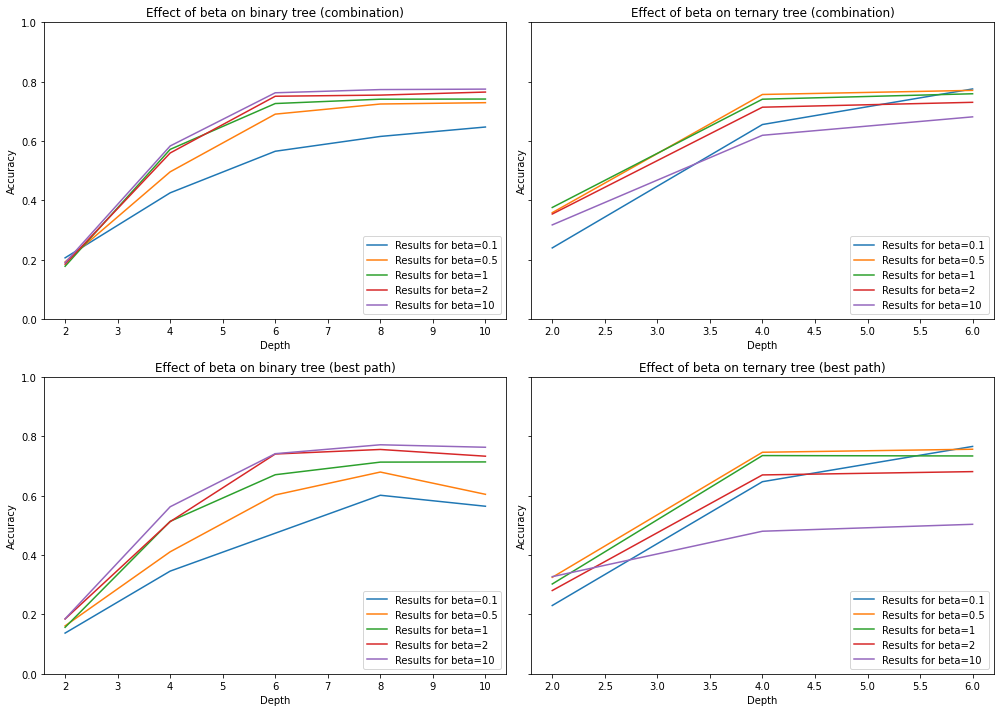

In [9]:
beta_fig, ((beta_ax11, beta_ax12), (beta_ax21, beta_ax22)) = \
    plt.subplots(2, 2, sharey=True, sharex=False, tight_layout=True, figsize=(14, 10))

beta_ax11.set_ylim([0, 1])
beta_ax11.set_title("Effect of beta on binary tree (combination)")
beta_ax11.set_xlabel("Depth")
beta_ax11.set_ylabel("Accuracy")

beta_ax12.set_ylim([0, 1])
beta_ax12.set_title("Effect of beta on ternary tree (combination)")
beta_ax12.set_xlabel("Depth")
beta_ax12.set_ylabel("Accuracy")

beta_ax21.set_ylim([0, 1])
beta_ax21.set_title("Effect of beta on binary tree (best path)")
beta_ax21.set_xlabel("Depth")
beta_ax21.set_ylabel("Accuracy")

beta_ax22.set_ylim([0, 1])
beta_ax22.set_title("Effect of beta on ternary tree (best path)")
beta_ax22.set_xlabel("Depth")
beta_ax22.set_ylabel("Accuracy")

for beta, accuracies in zip(beta_vals, beta_results_binary_comb):
    beta_ax11.plot(binary_depth_vals, accuracies, label="Results for beta={}".format(beta))

for beta, accuracies in zip(beta_vals, beta_results_ternary_comb):
    beta_ax12.plot(ternary_depth_vals, accuracies, label="Results for beta={}".format(beta))

for beta, accuracies in zip(beta_vals, beta_results_binary_path):
    beta_ax21.plot(binary_depth_vals, accuracies, label="Results for beta={}".format(beta))

for beta, accuracies in zip(beta_vals, beta_results_ternary_path):
    beta_ax22.plot(ternary_depth_vals, accuracies, label="Results for beta={}".format(beta))

beta_ax11.legend(loc='lower right')
beta_ax12.legend(loc='lower right')
beta_ax21.legend(loc='lower right')
beta_ax22.legend(loc='lower right')
beta_fig.show()

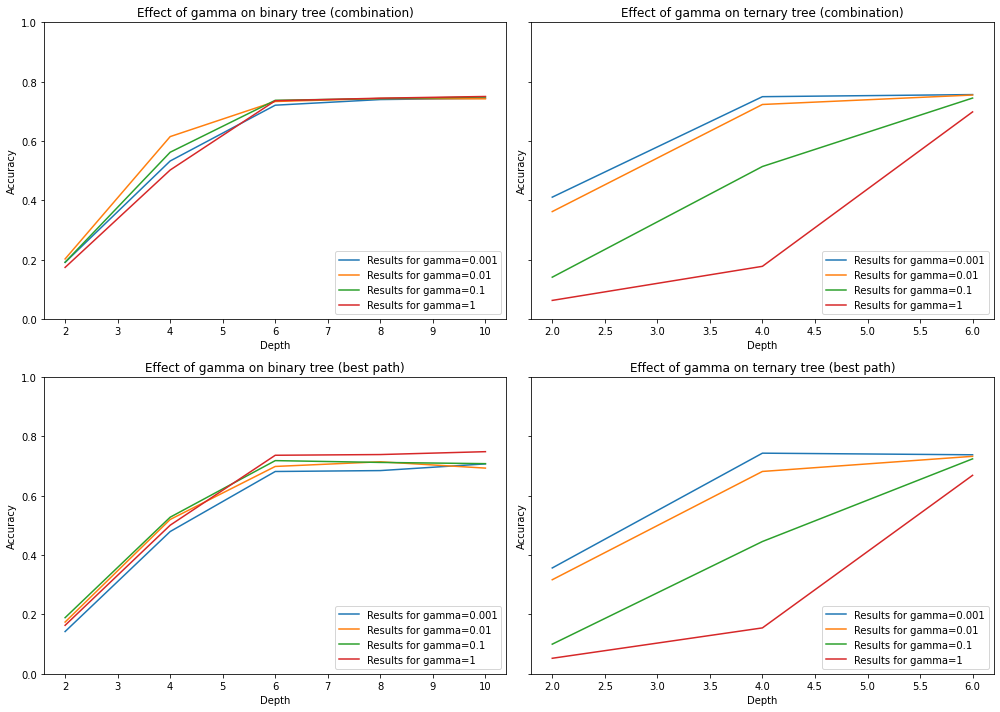

In [10]:
gamma_fig, ((gamma_ax11, gamma_ax12), (gamma_ax21, gamma_ax22)) = \
        plt.subplots(2, 2, sharey=True, sharex=False, tight_layout=True, figsize=(14, 10))

gamma_ax11.set_ylim([0, 1])
gamma_ax11.set_title("Effect of gamma on binary tree (combination)")
gamma_ax11.set_xlabel("Depth")
gamma_ax11.set_ylabel("Accuracy")

gamma_ax12.set_ylim([0, 1])
gamma_ax12.set_title("Effect of gamma on ternary tree (combination)")
gamma_ax12.set_xlabel("Depth")
gamma_ax12.set_ylabel("Accuracy")

gamma_ax21.set_ylim([0, 1])
gamma_ax21.set_title("Effect of gamma on binary tree (best path)")
gamma_ax21.set_xlabel("Depth")
gamma_ax21.set_ylabel("Accuracy")

gamma_ax22.set_ylim([0, 1])
gamma_ax22.set_title("Effect of gamma on ternary tree (best path)")
gamma_ax22.set_xlabel("Depth")
gamma_ax22.set_ylabel("Accuracy")

for gamma, accuracies in zip(gamma_vals, gamma_results_binary_comb):
    gamma_ax11.plot(binary_depth_vals, accuracies, label="Results for gamma={}".format(gamma))

for gamma, accuracies in zip(gamma_vals, gamma_results_ternary_comb):
    gamma_ax12.plot(ternary_depth_vals, accuracies, label="Results for gamma={}".format(gamma))
    
for gamma, accuracies in zip(gamma_vals, gamma_results_binary_path):
    gamma_ax21.plot(binary_depth_vals, accuracies, label="Results for gamma={}".format(gamma))

for gamma, accuracies in zip(gamma_vals, gamma_results_ternary_path):
    gamma_ax22.plot(ternary_depth_vals, accuracies, label="Results for gamma={}".format(gamma))

gamma_ax11.legend(loc='lower right')
gamma_ax12.legend(loc='lower right')
gamma_ax21.legend(loc='lower right')
gamma_ax22.legend(loc='lower right')
gamma_fig.show()

---
Next, I want to find out, how long trees of varying depth need to be trained and what their maximum performance is. Do we observe a depth and/or number of epochs where the performance does not increase further?

For this, experiment, I train binary trees of depth $\in \{2, 4, 6, 8, 10\}$ and ternary trees of depth $\in\{2, 4, 6\}$ for $30$ epochs and report performance on the test set after every epoch. $\beta$ and $\gamma$ are set to their default values of $\beta=1$ and $\gamma=0.01$.

In [11]:
binary_results_comb = []
binary_results_path = []

for depth in binary_depth_vals:
    classifier = BinarySoftDecisionTreeClassifier(depth, 20, 512)
    accuracies_comb, accuracies_path = train_pytorch_classifier(classifier, pytorch_data, epochs=30)
    binary_results_comb.append(accuracies_comb)
    binary_results_path.append(accuracies_path)

ternary_results_comb = []
ternary_results_path = []

for depth in ternary_depth_vals:
    classifier = SoftDecisionTreeClassifier(depth, 20, 512)
    accuracies_comb, accuracies_path = train_pytorch_classifier(classifier, pytorch_data, epochs=30)
    ternary_results_comb.append(accuracies_comb)
    ternary_results_path.append(accuracies_path)

  0%|          | 0/30 [00:00<?, ?it/s, Accuracy=0, Loss=0, Max. Path Prob.=0]

  0%|          | 0/30 [00:00<?, ?it/s, Accuracy=0, Loss=0, Max. Path Prob.=0]

  0%|          | 0/30 [00:00<?, ?it/s, Accuracy=0, Loss=0, Max. Path Prob.=0]

  0%|          | 0/30 [00:00<?, ?it/s, Accuracy=0, Loss=0, Max. Path Prob.=0]

  0%|          | 0/30 [00:00<?, ?it/s, Accuracy=0, Loss=0, Max. Path Prob.=0]

  0%|          | 0/30 [00:00<?, ?it/s, Accuracy=0, Loss=0, Max. Path Prob.=0]

  0%|          | 0/30 [00:00<?, ?it/s, Accuracy=0, Loss=0, Max. Path Prob.=0]

  0%|          | 0/30 [00:00<?, ?it/s, Accuracy=0, Loss=0, Max. Path Prob.=0]

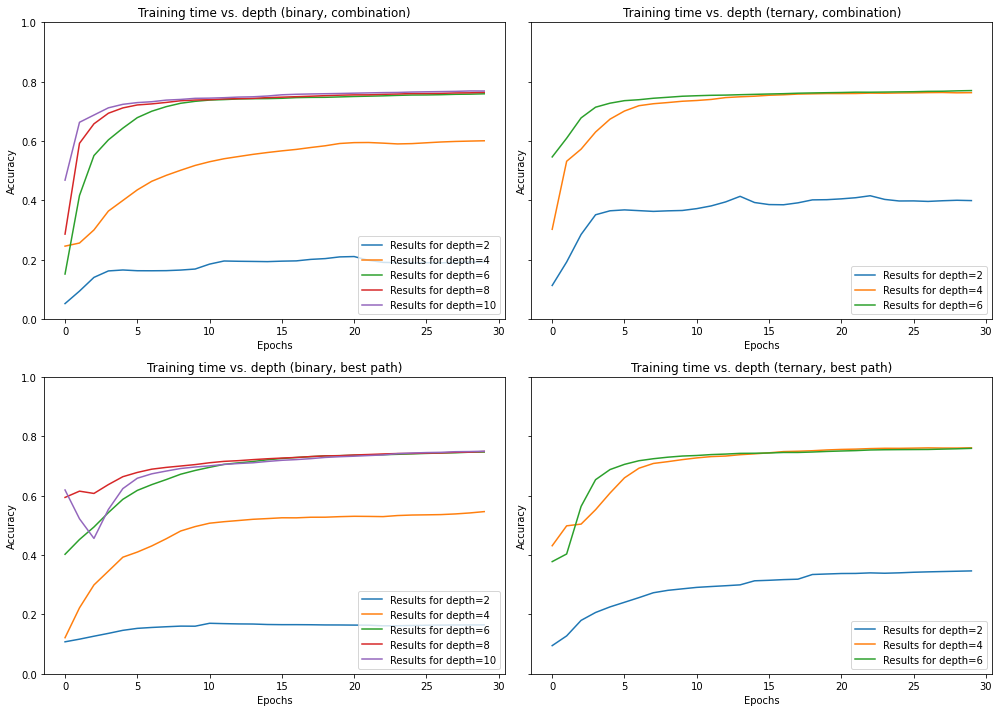

In [12]:
train_fig, ((train_ax11, train_ax12), (train_ax21, train_ax22)) = \
    plt.subplots(2, 2, sharey=True, sharex=False, tight_layout=True, figsize=(14, 10))

train_ax11.set_ylim([0, 1])
train_ax11.set_title("Training time vs. depth (binary, combination)")
train_ax11.set_xlabel("Epochs")
train_ax11.set_ylabel("Accuracy")

train_ax12.set_ylim([0, 1])
train_ax12.set_title("Training time vs. depth (ternary, combination)")
train_ax12.set_xlabel("Epochs")
train_ax12.set_ylabel("Accuracy")

train_ax21.set_ylim([0, 1])
train_ax21.set_title("Training time vs. depth (binary, best path)")
train_ax21.set_xlabel("Epochs")
train_ax21.set_ylabel("Accuracy")

train_ax22.set_ylim([0, 1])
train_ax22.set_title("Training time vs. depth (ternary, best path)")
train_ax22.set_xlabel("Epochs")
train_ax22.set_ylabel("Accuracy")

for depth, accuracies in zip(binary_depth_vals, binary_results_comb):
    train_ax11.plot(accuracies, label="Results for depth={}".format(depth))

for depth, accuracies in zip(ternary_depth_vals, ternary_results_comb):
    train_ax12.plot(accuracies, label="Results for depth={}".format(depth))
    
for depth, accuracies in zip(binary_depth_vals, binary_results_path):
    train_ax21.plot(accuracies, label="Results for depth={}".format(depth))

for depth, accuracies in zip(ternary_depth_vals, ternary_results_path):
    train_ax22.plot(accuracies, label="Results for depth={}".format(depth))

train_ax11.legend(loc='lower right')
train_ax12.legend(loc='lower right')
train_ax21.legend(loc='lower right')
train_ax22.legend(loc='lower right')
train_fig.show()

---
#### Comparison to Decision Trees and Random Forests (wrt. depth) / MLP (wrt. width)

In this experiment, I compare the performance of differentiable decision trees to the performance of decision tree classifiers and random forest classifiers. In particular, I vary the depth of the trees. I want to find out how important the depth is for the different classifiers.

For the random forest classifier, I use $512$ random decision trees. All other hyperparameters take their default value (provided by `sklearn`).

Additionally, I want to compare the performance of differentiable decision trees to the performance of MLPs. However, it is impractical to vary the depth of an MLP. Therefore, as a proxy, I use MLPs with $1$ hidden layer, and vary the width. If a tree has depth $d$, the corresponding MLP has width $2^d$, that is the MLP has $2^d$ hidden units. The MLP is trained using the Adam optimiser and batch size $32$.

In [13]:
max_depth = 10
depths = list(range(2, max_depth+1))

# Calculate prediction scores for Binary Soft Decision Tree
binary_soft_decision_tree_scores_comb = []
binary_soft_decision_tree_scores_path = []
binary_soft_decision_tree_iter = trange(2, max_depth+1)
binary_soft_decision_tree_iter.set_description("Training Binary Soft Decision Tree")
for depth in binary_soft_decision_tree_iter:
    binary_soft_decision_tree_classifier = BinarySoftDecisionTreeClassifier(depth, 20, 512)
    accuracies_comb, accuracies_path = \
        train_pytorch_classifier(binary_soft_decision_tree_classifier, pytorch_data)
    binary_soft_decision_tree_scores_comb.append(accuracies_comb[-1])
    binary_soft_decision_tree_scores_path.append(accuracies_path[-1])

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s, Accuracy=0, Loss=0, Max. Path Prob.=0]

  0%|          | 0/12 [00:00<?, ?it/s, Accuracy=0, Loss=0, Max. Path Prob.=0]

  0%|          | 0/12 [00:00<?, ?it/s, Accuracy=0, Loss=0, Max. Path Prob.=0]

  0%|          | 0/12 [00:00<?, ?it/s, Accuracy=0, Loss=0, Max. Path Prob.=0]

  0%|          | 0/12 [00:00<?, ?it/s, Accuracy=0, Loss=0, Max. Path Prob.=0]

  0%|          | 0/12 [00:00<?, ?it/s, Accuracy=0, Loss=0, Max. Path Prob.=0]

  0%|          | 0/12 [00:00<?, ?it/s, Accuracy=0, Loss=0, Max. Path Prob.=0]

  0%|          | 0/12 [00:00<?, ?it/s, Accuracy=0, Loss=0, Max. Path Prob.=0]

  0%|          | 0/12 [00:00<?, ?it/s, Accuracy=0, Loss=0, Max. Path Prob.=0]

In [14]:
# Calculate prediction scores for Decision Tree
decision_tree_scores = []
decision_tree_iter = trange(2, max_depth+1)
decision_tree_iter.set_description("Training Decision Trees")
for depth in decision_tree_iter:
    decision_tree_classifier = DecisionTreeClassifier(max_depth=depth)
    decision_tree_classifier.fit(X_train, y_train)
    accuracy = decision_tree_classifier.score(X_test, y_test)
    decision_tree_scores.append(accuracy)
    
# Calculate prediction scores for Random Forest
random_forest_scores = []
random_forest_iter = trange(2, max_depth+1)
random_forest_iter.set_description("Training Random Forests")
for depth in random_forest_iter:
    random_forest_classifier = RandomForestClassifier(max_depth=depth, n_estimators=512, n_jobs=20)
    random_forest_classifier.fit(X_train, y_train)
    accuracy = random_forest_classifier.score(X_test, y_test)
    random_forest_scores.append(accuracy)

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

In [15]:
# Calculate prediction scores for MLP
mlp_scores = []
mlp_iter = trange(2, max_depth+1)
mlp_iter.set_description("Training MLPs")
for width in mlp_iter:
    mlp_classifier = MLPClassifier((2**width,), batch_size=32)
    mlp_classifier.fit(X_train, y_train)
    accuracy = mlp_classifier.score(X_test, y_test)
    mlp_scores.append(accuracy)

  0%|          | 0/9 [00:00<?, ?it/s]

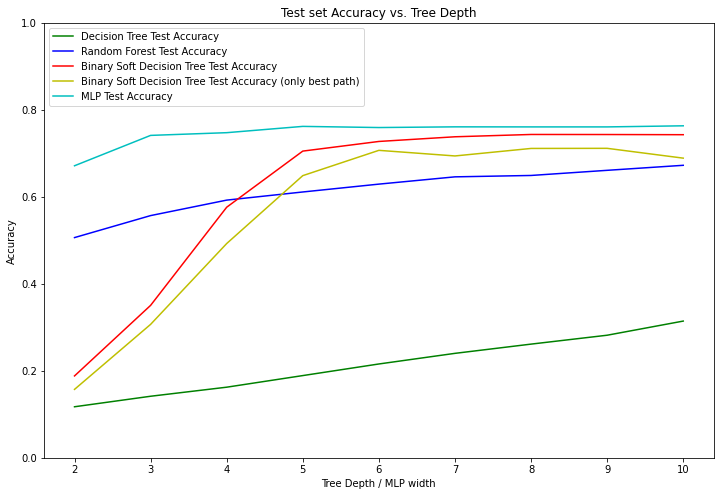

In [16]:
fig, ax = plt.subplots(1, 1, figsize=(12, 8))

ax.plot(depths, decision_tree_scores, 'g', label='Decision Tree Test Accuracy')
ax.plot(depths, random_forest_scores, 'b', label='Random Forest Test Accuracy')
ax.plot(depths, binary_soft_decision_tree_scores_comb, 'r', label='Binary Soft Decision Tree Test Accuracy')
ax.plot(depths, binary_soft_decision_tree_scores_path, 'y',
         label='Binary Soft Decision Tree Test Accuracy (only best path)')
ax.plot(depths, mlp_scores, 'c', label="MLP Test Accuracy")

ax.set_title('Test set Accuracy vs. Tree Depth')
ax.set_xlabel('Tree Depth / MLP width')
ax.set_ylabel('Accuracy')
ax.set_ylim([0, 1])
ax.legend(loc='upper left')

fig.show()

### Analysis

From the conducted experiments, we the following conclusions can be drawn:

 1. Both binary trees and ternary trees are relatively robust wrt. changes of hyperparameters ($\beta$ and $\gamma$). Generally, lower-entropy solutions seem to yield better performance (high $\beta$ for binary trees, low $\beta$ for ternary trees). However, this can be achieved much better by adjusting $\beta$ than by increasing $\gamma$. Too high $\gamma$ has negative effects on the performance. This is most obvious for ternary trees.
 2. The trees need relatively few epochs until the test set performance saturates. Also,  the trees need a certain depth in order to achieve maximum performance, but increasing depth more doesn't increase performance further.
 3. Differentiable Decision Trees (both using a weighted combination of distributions and using only the most probable path) perform better than Decision Trees and Random Forests but worse than MLPs. This suggests that they constitute an acceptable middle-ground between neural networks and random forests, both in terms of interpretability and performance.
 
Obviously, these observations result from experiments on a single dataset. For a more complete overview, more experiments on different datasets are necessary.